In [74]:
import numpy as np
from scipy.stats import bernoulli
import matplotlib as plt
from matplotlib import pyplot

In [18]:
class BernoulliBandit :
    def __init__ (self , means):
        for i in means:
            assert(i <= 1 and i >= 0)
        self.means = means
        self.k = len(means)
        self.best_mean = max(means)
        self.regret = 0
# Function should return the number of arms
    def get_K( self ):
         return self.k
# Accepts a parameter 0 <= a <= K -1 and returns the
# realisation of random variable X with P(X = 1) being
# the mean of the (a +1) th arm .
    def pull (self , a):
        self.regret += (self.best_mean - self.means[a])
        return bernoulli.rvs(self.means[a], size=1)

    def get_regret ( self ):
        return self.regret

In [38]:
def ETC(n, m, bandit):
    k = bandit.k
    rewards= np.zeros(n)
    total_reward=0
    actions = np.zeros(n)
    for i in range(n):
        if(i<= m*k - 1):
            rewards[i] = bandit.pull(i%k)
            total_reward += rewards[i]
            actions[i] = i%k
        else: 
            if(i == m*k): ##optimization
                best_mean_index = np.argmax(np.mean(np.transpose(np.reshape(rewards[0:m*k], (m,k))),1))
            actions[i] = best_mean_index
            rewards[i] = bandit.pull(best_mean_index)
            total_reward += rewards[i]
    observed_random_regret = n * bandit.best_mean - total_reward
    return np.array([(i,j) for (i,j) in zip(actions,rewards)]), observed_random_regret

In [39]:
bandit = BernoulliBandit([0.3,0.6,0.9])
ETC(100,5,bandit)

(array([[0., 0.],
        [1., 1.],
        [2., 1.],
        [0., 1.],
        [1., 0.],
        [2., 1.],
        [0., 1.],
        [1., 1.],
        [2., 1.],
        [0., 0.],
        [1., 1.],
        [2., 0.],
        [0., 0.],
        [1., 1.],
        [2., 1.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 0.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1

In [ ]:
trials = 100
horizon = 500
mean_regrets = np.zeros(50)
for m in range(2,101,2): ## m = [2,4,...,50]
    for i in range(trials):
        bandit= BernoulliBandit([0.5,0.6,0.7])
        results, observed_random_regret = ETC(horizon,m,bandit)
        mean_regrets[int(m/2) - 1] = (mean_regrets[int(m/2) - 1] * i + bandit.get_regret())/(i+1) 

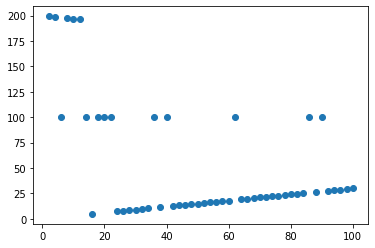

In [89]:
pyplot.scatter(range(2,101,2), r)